In [1]:
%reload_ext autoreload
%autoreload 2

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import time
from IPython.display import HTML

from molecular_dynamics import *

matplotlib.rcParams['animation.embed_limit'] = 2**128

# 4. Molecular dynamics
_Kevin Vonk, Apr 2020, March-April 2021_


## Part 1
#### 1a)

Harmonic oscillators are partly characterised by their frequency. This frequency in turn dictates the time scale (or period) of the oscillation. This is given by
\begin{equation}
    T = 2\pi\sqrt{\frac{m}{k}}.
\end{equation}
Given that $m = k = 1$, this reduces to $T = 2\pi$.

Using trial and error, I determined that for a grid spacing of $\frac{T}{45}$ the variation in the energy deviation becomes smaller than the requested $5\cdot 10^{-3}$

The analytical solution for this simple harmonic oscillator is
\begin{equation}
    x(t) = A\cos{\left(\sqrt{\frac{k}{m}}t + \phi\right)}.
\end{equation}
We see that our computed result for the harmonic oscillator follows this general solution nicely. The initial conditions are random every run, so it becomes more difficult to compare the two in a plot directly. However, the initial conditions influence the amplitude and phase shift only.

A plot of the relevant energies in this system can also be found below

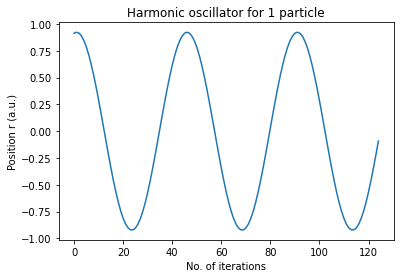

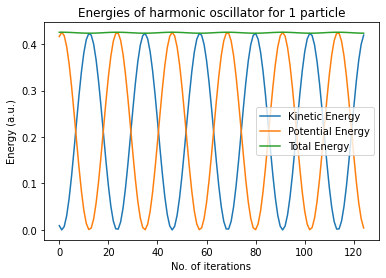

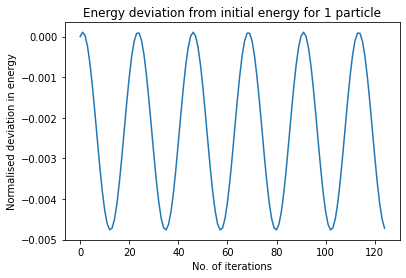

In [2]:
force = Force().spring_simple()
pm = ParticleManager(1, (0,1), (0,1)).set_initial_a(force)
grid = Grid(pm, 2*np.pi/45, force)

iter = 125

x = []
K = []
V = []

for i in range(iter):
    grid.update()
    x.append(grid.pm.r[0][0])
    K.append(0.5*grid.pm.v[0]**2)
    V.append(0.5*grid.pm.r[0]**2)
    
E = np.array([k+v for k, v in zip(K,V)])

plt.plot(range(iter), x)
plt.xlabel("No. of iterations")
plt.ylabel("Position r (a.u.)")
plt.title("Harmonic oscillator for 1 particle")
plt.figure()
plt.plot(range(iter), K, label="Kinetic Energy")
plt.plot(range(iter), V, label="Potential Energy")
plt.plot(range(iter), E, label="Total Energy")
plt.xlabel("No. of iterations")
plt.ylabel("Energy (a.u.)")
plt.title("Energies of harmonic oscillator for 1 particle")
plt.legend()
plt.figure()
plt.plot(range(iter), (E - E[0]) / E[0])
plt.xlabel("No. of iterations")
plt.ylabel("Normalised deviation in energy")
plt.title("Energy deviation from initial energy for 1 particle");

#### 1b)

It seems from the results below that the step size $\frac{T}{45}$ is still accurate enough to be used. For the first run $x_0 = 1$ and $v_0 = 1$. The results for other values of $x_0$ and $v_0$ are given below.

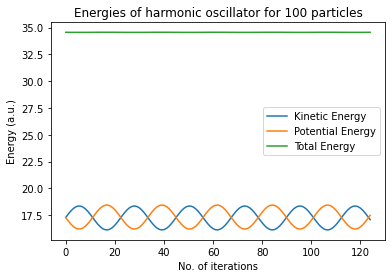

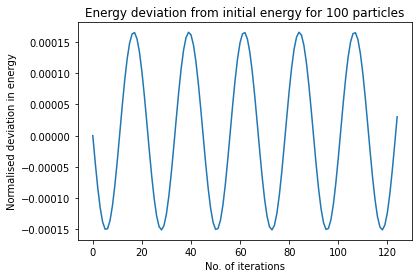

In [3]:
pm = ParticleManager(N=100).set_initial_a(force)
grid = Grid(pm, 2*np.pi/45, force)

K = []
V = []

for i in range(iter):
    grid.update()
    K.append(0.5*np.sum(grid.pm.v**2))
    V.append(0.5*np.sum(grid.pm.r**2))

E = np.array([k+v for k, v in zip(K,V)])
    
plt.plot(range(iter), K, label="Kinetic Energy")
plt.plot(range(iter), V, label="Potential Energy")
plt.plot(range(iter), E, label="Total Energy")
plt.xlabel("No. of iterations")
plt.ylabel("Energy (a.u.)")
plt.title("Energies of harmonic oscillator for 100 particles")
plt.legend()

plt.figure()
plt.plot(range(iter), (E - E[0]) / E[0])
plt.xlabel("No. of iterations")
plt.ylabel("Normalised deviation in energy")
plt.title("Energy deviation from initial energy for 100 particles");

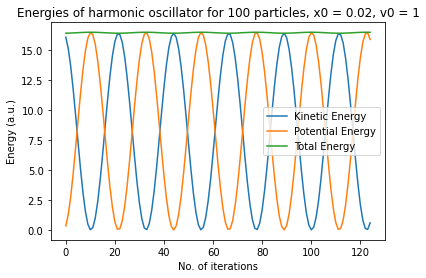

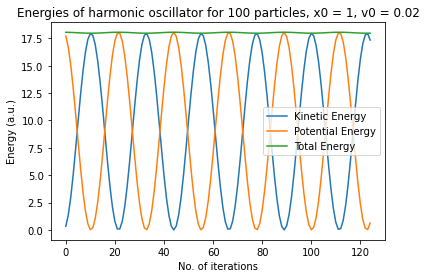

In [4]:
pool = ((1/50, 1), (1, 1/50))

for p in pool:
    pm = ParticleManager(N=100, rlim=(-p[0], p[0]), vlim=(-p[1], p[1])).set_initial_a(force)
    grid = Grid(pm, 2*np.pi/45, force)

    K = []
    V = []

    for i in range(iter):
        grid.update()
        K.append(0.5*np.sum(grid.pm.v**2))
        V.append(0.5*np.sum(grid.pm.r**2))

    E = np.array([k+v for k, v in zip(K,V)])
    
    plt.figure()
    plt.plot(range(iter), K, label="Kinetic Energy")
    plt.plot(range(iter), V, label="Potential Energy")
    plt.plot(range(iter), E, label="Total Energy")
    plt.xlabel("No. of iterations")
    plt.ylabel("Energy (a.u.)")
    plt.title(f"Energies of harmonic oscillator for 100 particles, x0 = {p[0]}, v0 = {p[1]}")
    plt.legend();

We can make some logical, but notable statements from these two plots. In the case where $x_0$ is small, the kinetic energy starts out large. This makes sense, since we have a lot of velocity. There is not a lot of gain to be made by moving towards the center of the well, since we are already so close to it.
In the other plot, the roles are reversed. We have plenty of energy to gain by moving towards the center of the well. Our velocity however is rather low, which is reflected by the kinetic energy.

The result which most closely mimics the equipartition of energy is when $x_0 = 1$ and $v_0 = 1$ (the first plot of 1b). In this case, both the kinetic and potential energy contribute roughly half towards the total energy. Additionaly, their variation is far more limited/constant compared to the other two scenarios.

#### 1c)

In order to implement the nearest neighbours interaction, we must obtain the force term out of the given total energy term. The force on the particles is deduced from the potential energy as follows.
\begin{equation}
    F = -\nabla V = -\nabla \frac{k}{2}\sum_i^N\left(x_{i+1}-x_{i}\right)^2.
\end{equation}
Considering the force $F$ on a particular particle $n$,
\begin{aligned}
    F_n &= -\frac{k}{2}\frac{\partial}{\partial x_n}\left(... + (x_n - x_{n-1})^2 + (x_{n+1} - x_n)^2 + ...\right) \\
    &= -k\left(\left(x_n - x_{n-1}\right) - \left(x_{n+1} - x_n\right)\right) \\
    &= -k\left(2x_n - x_{n-1} - x_{n+1}\right)
\end{aligned}

Running the script about 10 times, it looks like the $\frac{T}{45}$ grid spacing is still barely accurate enough. If I decrease it to $\frac{T}{100}$ however, the deviations in the total energy (which should be constant) decrease quite dramatically. Hence, I will use this grid spacing going forward.

Looking at the results found below, all three initial conditions move towards a state of equipartition of energy. It does seem that it takes a number of iterations before this state is reached. Taking about 50 iterations as an equilibrium time seems to ensure the system is in equilibrium every run.

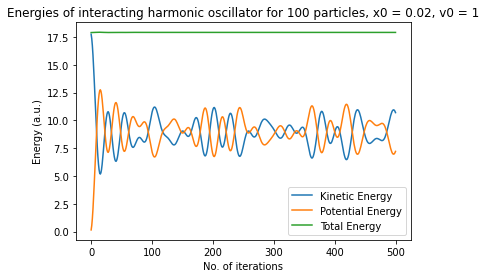

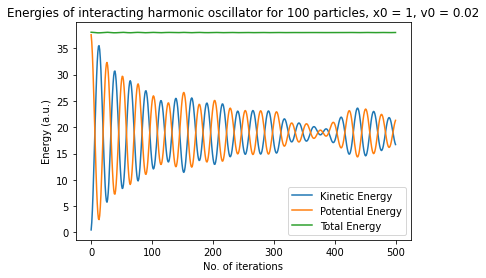

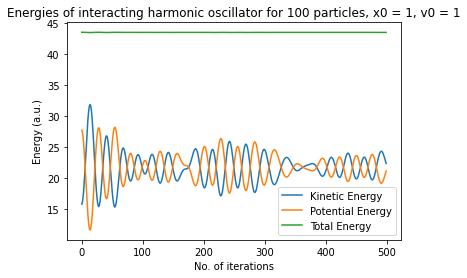

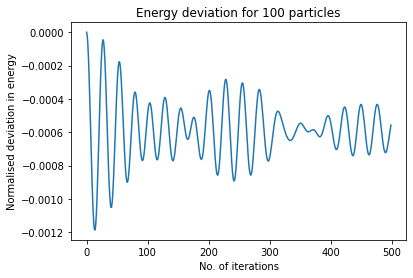

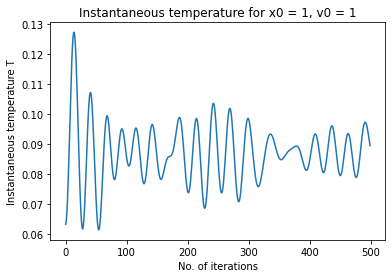

In [5]:
pool = ((1/50, 1), (1, 1/50), (1, 1))

iter = 500

for p in pool:
    pm = ParticleManager(N=100, rlim=(-p[0], p[0]), vlim=(-p[1], p[1])).remove_translation().set_initial_a(force)
    force = Force().spring_nearest_neighbours()
    grid = Grid(pm, 2*np.pi/100, force)

    K = []
    V = []
    v = []

    for i in range(iter):
        grid.update()
        K.append(0.5*np.sum(grid.pm.v**2))
        V.append(0.5*np.sum((np.roll(grid.pm.r, -1) - grid.pm.r)**2))
        v.extend(grid.pm.v[:,0])

    E = np.array([k+v for k, v in zip(K,V)])
    
    plt.figure()
    plt.plot(range(iter), K, label="Kinetic Energy")
    plt.plot(range(iter), V, label="Potential Energy")
    plt.plot(range(iter), E, label="Total Energy")
    plt.xlabel("No. of iterations")
    plt.ylabel("Energy (a.u.)")
    plt.title(f"Energies of interacting harmonic oscillator for 100 particles, x0 = {p[0]}, v0 = {p[1]}")
    plt.legend();

plt.figure()
plt.plot(range(iter), (E - E[0]) / E[0])
plt.xlabel("No. of iterations")
plt.ylabel("Normalised deviation in energy")
plt.title("Energy deviation for 100 particles")

plt.figure()
plt.plot(range(iter), 2*np.array(K) / len(K))
plt.xlabel("No. of iterations")
plt.ylabel("Instantaneous temperature T")
plt.title(f"Instantaneous temperature for x0 = {p[0]}, v0 = {p[1]}");

In order to compute the instantaneous temperature, we will use the last run where $x_0 = 1$ and $v_0 = 1$. The first 50 iterations have been dropped to allow the system to find itself in equilibrium.

In [6]:
T = 2 / len(grid) * np.array(K[50:])
T_avg = np.mean(T)
print(f"The average temperature <T> = {T_avg} (a.u.)")

The average temperature <T> = 0.4329948566804383 (a.u.)


Lastly then, let us take a look at the distribution of velocities. The comparision to the Boltzmann distribution can be found below. The calculated average temperature is used for the Boltzmann distribution, as well as $k_B = 1$. Furthermore, the Boltzmann distribution has been renormalised based on the integral of itself, such that it more closely aligns with the computed velocity distribution.

What we can see from the figure below, is that the velocities present in the system after its initial equilibrium period closely follow the Boltzmann distribution.

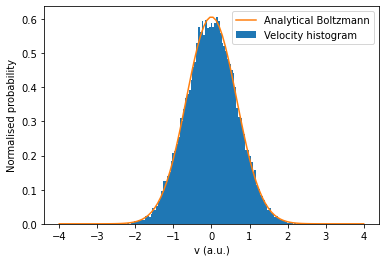

In [7]:
k = m = 1

e = lambda v: 0.5*m*v**2
v_ana = np.linspace(-4, 4, 100)
p_ana = np.exp(-e(v_ana) / (k*T_avg))

plt.hist(v[50*100:], bins=100, density=True, label="Velocity histogram")
plt.plot(v_ana, p_ana / np.trapz(p_ana, x=v_ana), label="Analytical Boltzmann")
plt.xlabel("v (a.u.)")
plt.ylabel("Normalised probability")
plt.legend();

#### 2a)

Utilising the definition of the Lennard-Jones pair potential, we are able to define a force $\vec{f_{ij}}$. This is the force exerted on a particle by the nearest other particle. Starting from the definition of the Lennard-Jones potential (and only considering the case where $r \leq R_c$),
\begin{aligned}
    \vec{f_{ij}} &= -\nabla_i u(r_{ij}) \\
    &= -\frac{\partial}{\partial r_{ij}}\left(4\epsilon \left[\left(\frac{\sigma}{r_{ij}}\right)^{12} - \left(\frac{\sigma}{r_{ij}}\right)^6\right]\right)\hat{r} \\
    &= 48\epsilon \frac{\sigma^{12}}{r_{ij}^{13}} - 24\epsilon \frac{\sigma^6}{r_{ij}^7} \\
    &=
    \begin{cases}
        \frac{24\epsilon}{r_{ij}}\left[2\left(\frac{\sigma}{r_{ij}}\right)^{12} - \left(\frac{\sigma}{r_{ij}}\right)^6\right]\hat{r} & r_{ij} \leq R_c \\
        0 & r_{ij} \gt R_c
    \end{cases}
\end{aligned}
Furthermore, $\vec{f_{ij}} = -\vec{f_{ji}}$. The force of particle i on particle j is exactly the same as the other way around, since they are at equal distance from another. Only the directionality changes, which is indicated by the minus.

In order to remove the dimensions from the problem, we start with the energy $E$.
\begin{equation}
    \tilde{E} = \frac{E}{\epsilon} = \frac{K}{\epsilon} + \frac{V}{\epsilon}.
\end{equation}
The kinetic energy can not be rewritten further. For the potential energy however, we can rewrite the Lennard-Jones potential as,
\begin{equation}
    \tilde{u}_{LJ}(\tilde{r}) = 4\left(\frac{1}{\tilde{r}^{12}} - \frac{1}{\tilde{r}^6}\right).
\end{equation}
This alteration of the Lennard-Jones potential also changes the exerted force $\vec{f_{ij}}$ too. Following the same derivation steps as above, we obtain (for the case where $\tilde{r_{ij}} \leq \tilde{R_c}$),
\begin{equation}
    \vec{\tilde{f_{ij}}} = \frac{24}{\tilde{r_{ij}}}\left(\frac{2}{\tilde{r}^{12}} - \frac{1}{\tilde{r}^6}\right)\hat{\tilde{r}}.
\end{equation}

For Argon gas, the temperature $T = 120K$ and the pressure $P = 4,16 \cdot 10^{7} N/m^2$.

#### 2b)

The useful property provided by the minimum image criterion is that when the distance $r$ to another particle becomes larger than $\frac{1}{2}L$, the same particle can be found at a closer distance in an imaged system. Or, because we will not be dealing with actual imaging programmatically, we can calculate where said image particle is supposed to be. This concept only works because of the periodic boundary conditions, which ensures a "wrap around", much like a Bloch wave does when talking about electrons.

The periodic boundary conditions also allow us to keep all the particles inside the $L\times L$ box. We can do this by using the modulo operator on the position after it has been updated.

#### 2c)
The code has been implemented in 2d), so I refer to that paragraph for the Python implementation.

In the initialisation function for the particle manager, I use the given density to compute the required $L$. Using this $L$, I create a crystal lattice structure such that all the particles are spaced evenly apart in the 3D space. Then, I will add a small random offset to each particle to break the fully symmetric structure. This can be seen in the "Initial" figure of 2d). In this same function, velocities are added using a uniform distribution to all the particles. They are bounded by the ```vlim``` parameter.

Next, in order to finalise the particles, I remove the translation and scale it to a requested temperature. The translation is removed by computing the momentum of all the particles, i.e. the total system momentum or the center-of-mass momentum. This momentum is used to compute the center-of-mass velocity, which is subtracted from all the particles. This ensures that the center-of-mass velocity is zero. The temperature of the system is computed from eq. (3.2) of Ercolessi,
\begin{equation*}
    T = \frac{2}{3N}K,
\end{equation*}
where $k_B = 1$. The ratio between this temperature and the requested temperature is computed, and we multiply the velocities by the square root of this ratio in order to scale the velocities correctly:
\begin{equation*}
    v_i = v_i * \sqrt{\frac{T_{in}}{T}}.
\end{equation*}

#### 2d)
The parameters have been set and the Python implementation can be found below. In order to get an idea about the energy fluctuations, we can plot $(E(t) - E_0)/E_0$, where $E_0$ can either refer to the initial energy at $t=0$, or to the average energy over the whole run. Because intuitively it feels more correct to use the average energy, I will use that to plot the energy fluctuations. From this energy fluctuation I determined that $dt = 0.005$ is a reasonable time step, which limits the variations to $5 \cdot 10^{-3}$, which is reasonable.

All the plots are found below this code block.

Because of the random offset I already applied to all the particles, it seems that the system is already roughly in equilibrium from the first iteration. However, because there is still a slight decay in the energy fluctuations, and because the system might need more time in other configurations, I will use $50$ iterations for the system to find itself in equilibrium. Using this I computed the average temperature of the system, and the velocity distribution. These results are also found below. In the velocity distribution we see that the Boltzmann distribution is followed nicely. The average temperature is $<T> = 2.75$

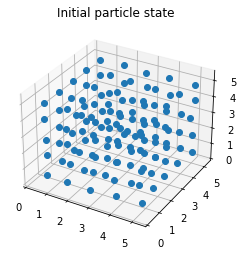

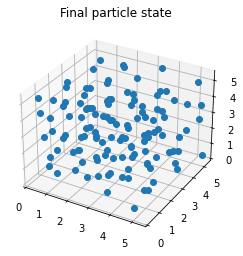

In [8]:
N = 125
iter = 500
dt = 0.005

rc = 2.5

force = Force().lennard_jones(rc = rc)
pm = ParticleManager(N=N, rho=0.75, vlim=(-0.1, 0.1), Ndim=3, as_grid=True).remove_translation().scale(T=3).set_initial_a(force)
grid = Grid(pm, dt=dt, force=force)

if pm.bounds[1] <= rc:
    raise Exception(f"2 * Rc should be larger than the bounds! L={pm.bounds[1]:.2f}, Rc={rc}")

fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")
ax.set_xlim3d(pm.bounds)
ax.set_ylim3d(pm.bounds)
ax.set_zlim3d(pm.bounds)
ax.set_title("Initial particle state")
scatter, = ax.plot(np.copy(grid.pm.r[:,0]), np.copy(grid.pm.r[:,1]), np.copy(grid.pm.r[:,2]), marker="o", linestyle="")

K = np.zeros(iter)
V = np.zeros(iter)
vx = np.zeros(iter * N)

for i in range(iter):
    V[i] = grid.update()
    K[i] = 0.5 * np.sum(grid.pm.v**2)
    vx[N*i:N*(i+1)] = grid.pm.v[:,0]

E = np.array([k+v for k, v in zip(K,V)])

fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")
ax.set_xlim3d(pm.bounds)
ax.set_ylim3d(pm.bounds)
ax.set_zlim3d(pm.bounds)
ax.set_title("Final particle state")
scatter, = ax.plot(np.copy(grid.pm.r[:,0]), np.copy(grid.pm.r[:,1]), np.copy(grid.pm.r[:,2]), marker="o", linestyle="");

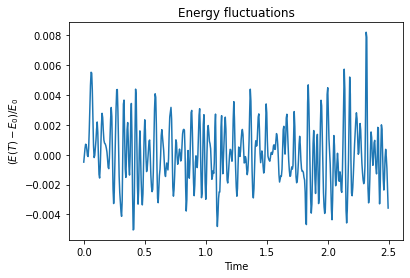

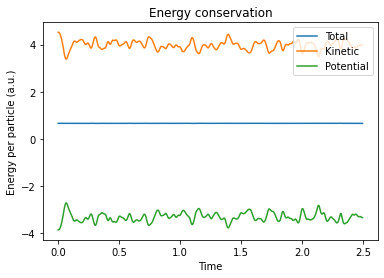

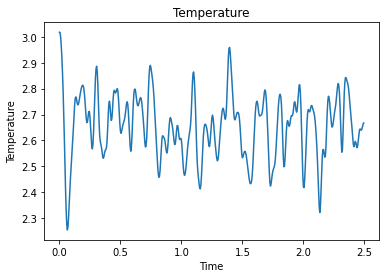

In [9]:
plt.figure()
plt.title("Energy fluctuations")
plt.plot(dt * np.arange(iter), (E - np.mean(E)) / np.mean(E))
plt.xlabel("Time")
plt.ylabel(r"$(E(T) - E_0)/E_0$")

plt.figure()
plt.title("Energy conservation")
plt.plot(dt * np.arange(iter), E/N, label="Total")
plt.plot(dt * np.arange(iter), K/N, label="Kinetic")
plt.plot(dt * np.arange(iter), V/N, label="Potential")
plt.xlabel("Time")
plt.ylabel("Energy per particle (a.u.)")
plt.legend()

plt.figure()
plt.title("Temperature")
plt.plot(dt * np.arange(iter), 2/(3*N)*np.array(K))
plt.xlabel("Time")
plt.ylabel("Temperature");

In [10]:
T = 2 / (3*len(grid)) * np.array(K[50:])
T_avg = np.mean(T)
print(f"The average temperature <T> = {T_avg} (a.u.)")

The average temperature <T> = 2.6531935148796317 (a.u.)


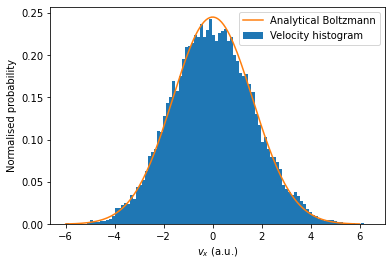

In [11]:
e = lambda v: 0.5*m*v**2
v_ana = np.linspace(-6, 6, 150)
p_ana = np.exp(-e(v_ana) / (k*T_avg))

plt.hist(vx, bins=100, density=True, label="Velocity histogram")
plt.plot(v_ana, p_ana / np.trapz(p_ana, x=v_ana), label="Analytical Boltzmann")
plt.xlabel(r"$v_x$ (a.u.)")
plt.ylabel("Normalised probability")
plt.legend();

## Part 2
#### 1
The timestep that I picked is $dt = 0.005$, as this ensures that the fluctuations in the total energy ($(E-E_0)/E_0$) are greatly smaller than those in the potential energy ($(V-V_0)/V_0$), see the plot below. We discard $N_e = 50$ steps, as discussed in part 1. Over 5 runs, the average temperature $<T>_5 = 1.86$, which implies a typical deviation of $\delta T = 0.14$.

In [12]:
dt = 0.005

T = lambda k: 2 / (3*N) * k[50:]

pm = ParticleManager(N=N, rho=0.7, vlim=(-0.1, 0.1), Ndim=3, as_grid=True).remove_translation().scale(T=2).set_initial_a(force)
grid = Grid(pm, dt=dt, force=force)

if pm.bounds[1] <= rc:
    raise Exception(f"2 * Rc should be larger than the bounds! L={pm.bounds[1]:.2f}, Rc={rc}")

K = np.zeros(iter)
V = np.zeros(iter)

for i in range(iter):
    V[i] = grid.update()
    K[i] = 0.5 * np.sum(grid.pm.v**2)

E = np.array([k+v for k, v in zip(K,V)])

print(f"The average temperature this run was <T>={np.mean(T(K)):.2f}")

The average temperature this run was <T>=1.85


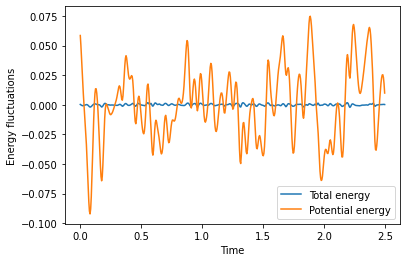

In [13]:
plt.plot(dt*np.arange(iter), (E - np.mean(E))/np.mean(E), label="Total energy")
plt.plot(dt*np.arange(iter), (V - np.mean(V))/np.mean(V), label="Potential energy")
plt.xlabel("Time")
plt.ylabel("Energy fluctuations")
plt.legend();

#### 2a)
No, during these initial $N_T$ steps, we are constantly changing the velocity, and thus the kinetic energy. This is akin to adding or removing energy. Thus, the energy is not conserved here.


#### 2b)
For $N_T = 10$ I was able to obtain average temperatures $<T>$ that were very close to $T_0$ (within $0.05$ of $T_0$). The code used to find this is found below. The value for $N_T$ was determined using trial-and-error.

In [14]:
T = lambda k: 2 / (3*N) * k

n_T = 10
n_e = 50
n_go = 500
T0 = 2

pm = ParticleManager(N=N, rho=0.7, vlim=(-0.1, 0.1), Ndim=3, as_grid=True).remove_translation().scale(T=T0).set_initial_a(force)
grid = Grid(pm, dt=dt, force=force)

if pm.bounds[1] <= rc:
    raise Exception(f"2 * Rc should be larger than the bounds! L={pm.bounds[1]:.2f}, Rc={rc}")

K = np.zeros(n_go)
V = np.zeros(n_go)

for _ in range(n_T):
    grid.update()
    grid.pm.scale(T=T0)

for _ in range(n_e):
    grid.update()

for i in range(n_go):
    V[i] = grid.update()
    K[i] = 0.5 * np.sum(grid.pm.v**2)

print(f"The average temperature this run was <T>={np.mean(T(K)):.2f}")

The average temperature this run was <T>=2.07


#### 2c)
Due to the decreased density of particles, $N_T$ had to be increased slightly in order for the $T_0 = 2$ case to be correct. However, in order for the average of the lower temperature case to correspond to its initial temperature, many more iterations were needed. Because of the lower temperature, the velocities are lower, ensuring that it takes longer for the particles to find themselves in a potential well. The more particles are located in such wells, the more accurately / correctly the velocities can be scaled.

The solution to this problem is simply to add more preparation steps $n_T$, but this comes at the cost of more computational effort, and thus computation time. In order to strike a balance between computation time and accuracy, I decided to take $n_T = 100$ in this case. I also bumped up the equilibration time for the same reason.

In [15]:
n_T = 100
n_e = 100
for T0 in (2, 0.9):
    pm = ParticleManager(N=N, rho=0.5, vlim=(-0.1, 0.1), Ndim=3, as_grid=True).remove_translation().scale(T=T0).set_initial_a(force)
    grid = Grid(pm, dt=dt, force=force)

    if pm.bounds[1] <= rc:
        raise Exception(f"2 * Rc should be larger than the bounds! L={pm.bounds[1]:.2f}, Rc={rc}")

    K = np.zeros(n_go)
    V = np.zeros(n_go)

    for _ in range(n_T):
        grid.update()
        grid.pm.scale(T=T0)

    for _ in range(n_e):
        grid.update()

    for i in range(n_go):
        V[i] = grid.update()
        K[i] = 0.5 * np.sum(grid.pm.v**2)
        
    print(f"The average temperature this run (T0 = {T0}) was <T> = {np.mean(T(K)):.2f}")

The average temperature this run (T0 = 2) was <T> = 1.90
The average temperature this run (T0 = 0.9) was <T> = 0.98


#### 3a)
From part 1, we know that we can write the total force acting on a particle $i$ as
$$
    \vec{F}_i = \sum_{j \neq i}^N \vec{f}_{ij}.
$$
Filling this in into the virial formula yields,
$$
    P = \rho k_B T + \frac{1}{3V}\left<\sum_{i=1}^N\sum_{j \neq i}^N \vec{f}_{ij} \cdot \vec{r}_i\right>.
$$
Now, we can split the term in the triangular brackets up into the interaction of particle $i$ on $j$ and the interaction of particle $j$ on $i$,
\begin{align*}
    \sum_{i=1}^N\sum_{j \neq i}^N \vec{f}_{ij} \cdot \vec{r}_i &= \frac{1}{2}\left(\sum_{i=1}^N\sum_{j \neq i}^N \vec{f}_{ij} \cdot \vec{r}_i + \sum_{i=1}^N\sum_{j \neq i}^N \vec{f}_{ji} \cdot \vec{r}_j\right).
\end{align*}
Because $f_{ij} = -f_{ji}$, we can rewrite this as,
\begin{align*}
    \frac{1}{2}\left(\sum_{i=1}^N\sum_{j \neq i}^N \vec{f}_{ij} \cdot \vec{r}_i + \sum_{i=1}^N\sum_{j \neq i}^N \vec{f}_{ji} \cdot \vec{r}_j\right) &= \frac{1}{2}\left(\sum_{i=1}^N\sum_{j \neq i}^N \vec{f}_{ij} \cdot \vec{r}_i - \sum_{i=1}^N\sum_{j \neq i}^N \vec{f}_{ij} \cdot \vec{r}_j\right), \\
    &= \frac{1}{2}\sum_{i=1}^N\sum_{j \neq i}^N \vec{f}_{ij} \cdot (\vec{r}_i - \vec{r}_j), \\
    &= \sum_{i=1}^N\sum_{j > i}^N \vec{f}_{ij} \cdot \vec{r}_{ij},
\end{align*}
where the summation range has been changed to drop the prefactor $1/2$. If we now fill this back into the virial formula, we obtain for the pressure,
$$
    P = \rho k_B T + \frac{1}{3V}\left<\sum_{i=1}^N\sum_{j > i}^N \vec{f}_{ij} \cdot \vec{r}_{ij}\right>,
$$
which is the requested expression.

Let us now use this expression in the computation of the pressure in our system. The code and the results are found below. We find that there is quite a large deviation in the computed pressure versus the pressure from the ideal gas law. From the run where I wrote this paragraph, I obtained $P_{verlet} = 6.11$, and $P_{ideal} = 1.61$, a difference of $4.5$.

In [16]:
T0 = 2
rho = 0.8

pm = ParticleManager(N=N, rho=rho, vlim=(-0.1, 0.1), Ndim=3, as_grid=True).remove_translation().scale(T=T0).set_initial_a(force)
grid = Grid(pm, dt=dt, force=force)

if pm.bounds[1] <= rc:
    raise Exception(f"2 * Rc should be larger than the bounds! L={pm.bounds[1]:.2f}, Rc={rc}")

K = np.zeros(n_go)
V = np.zeros(n_go)
P = np.zeros(n_go)

for _ in range(n_T):
    grid.update()
    grid.pm.scale(T=T0)

for _ in range(n_e):
    grid.update()

for i in range(n_go):
    V[i] = grid.update()
    K[i] = grid.pm.K
    P[i] = grid.pm.P
    
print(f"The average temperature this run was <T> = {np.mean(T(K)):.2f}, pressure P = {np.mean(P):.2f}")
print(f"The ideal gas law yields P = {np.mean(T(K)) * rho:.2f}")

The average temperature this run was <T> = 1.96, pressure P = 5.89
The ideal gas law yields P = 1.57


#### 3c)
We will vary the density between $0.1$ and $0.8$, using $10$ steps. The code and resulting graph are found below. From the graph we can determine that the ideal gas law holds for densities up to $\rho \approx 0.35$. After that, it is no longer a good approximation.

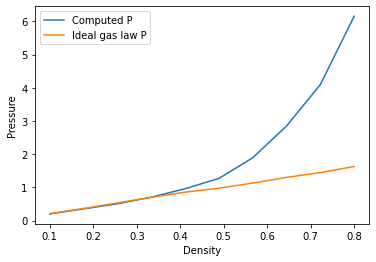

In [17]:
Pplot = np.zeros(10)
Tplot = np.zeros(Pplot.size)
rhos = np.linspace(0.1, 0.8, Pplot.size)

for j, rho in enumerate(rhos):
    pm = ParticleManager(N=N, rho=rho, vlim=(-0.1, 0.1), Ndim=3, as_grid=True).remove_translation().scale(T=T0).set_initial_a(force)
    grid = Grid(pm, dt=dt, force=force)

    if pm.bounds[1] <= rc:
        raise Exception(f"2 * Rc should be larger than the bounds! L={pm.bounds[1]:.2f}, Rc={rc}")

    K = np.zeros(n_go)
    V = np.zeros(n_go)
    P = np.zeros(n_go)

    for _ in range(n_T):
        grid.update()
        grid.pm.scale(T=T0)

    for _ in range(n_e):
        grid.update()

    for i in range(n_go):
        V[i] = grid.update()
        K[i] = grid.pm.K
        P[i] = grid.pm.P

    Pplot[j] = np.mean(P)
    Tplot[j] = np.mean(T(K))

plt.figure()
plt.plot(rhos, Pplot, label="Computed P")
plt.plot(rhos, rhos*Tplot, label="Ideal gas law P")
plt.xlabel("Density")
plt.ylabel("Pressure")
plt.legend();

#### 3c)
Same as in 3b), but now we have $T_0 = 0.8$ and will vary the density between $0.4$ and $0.8$, again in $10$ steps. From the figure, we do not observe the constant density in the coexistence region. Increasing $N_T$ and $N_e$ does not seem to improve this situation much.

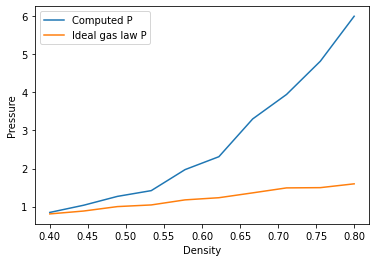

In [18]:
Pplot = np.zeros(10)
Tplot = np.zeros(Pplot.size)
rhos = np.linspace(0.4, 0.8, Pplot.size)
n_T = 250
n_e = 250

for j, rho in enumerate(rhos):
    pm = ParticleManager(N=N, rho=rho, vlim=(-0.1, 0.1), Ndim=3, as_grid=True).remove_translation().scale(T=0.8).set_initial_a(force)
    grid = Grid(pm, dt=dt, force=force)

    if pm.bounds[1] <= rc:
        raise Exception(f"2 * Rc should be larger than the bounds! L={pm.bounds[1]:.2f}, Rc={rc}")

    K = np.zeros(n_go)
    V = np.zeros(n_go)
    P = np.zeros(n_go)

    for _ in range(n_T):
        grid.update()
        grid.pm.scale(T=T0)

    for _ in range(n_e):
        grid.update()

    for i in range(n_go):
        V[i] = grid.update()
        K[i] = grid.pm.K
        P[i] = grid.pm.P

    Pplot[j] = np.mean(P)
    Tplot[j] = np.mean(T(K))

plt.figure()
plt.plot(rhos, Pplot, label="Computed P")
plt.plot(rhos, rhos*Tplot, label="Ideal gas law P")
plt.xlabel("Density")
plt.ylabel("Pressure")
plt.legend();

#### 4a)

The code and the resulting histogram are found below. We normalise $g(r)$ over $\rho$, $N_{go}$, $N$ and the volume of a shell element $dr$, $\frac{4 \pi}{3} (r^3 - (r - dr)^3)$. The shape of $g(r)$ is as we would expect, due to the large Lennard-Jones potential at small $r$ we indeed see no particles at small distances.

Because I skip particles $j < i$ in my code, I multiply the resuling histogram by two, in order to account for both particle interactions.

In [19]:
bins = 100
n_T = 100
n_e = 100
rho = 0.8

force = Force().lennard_jones(rc = rc)
pm = ParticleManager(N=N, rho=rho, vlim=(-0.1, 0.1), Ndim=3, as_grid=True).remove_translation().scale(T=2).set_initial_a(force).init_hist(bins)
grid = Grid(pm, dt=dt, force=force)

if pm.bounds[1] <= rc:
    raise Exception(f"2 * Rc should be larger than the bounds! L={pm.bounds[1]:.2f}, Rc={rc}")

K = np.zeros(n_go)
V = np.zeros(n_go)
P = np.zeros(n_go)

for _ in range(n_T):
    grid.update()
    grid.pm.scale(T=T0)

for _ in range(n_e):
    grid.update()

grid.pm._hist_rdy = True

for i in range(n_go):
    V[i] = grid.update()
    K[i] = grid.pm.K
    P[i] = grid.pm.P


Text(0, 0.5, 'g(r)')

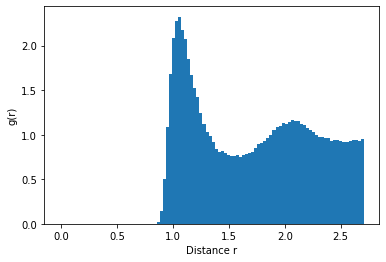

In [20]:
hist = 2*grid.pm._hist
bin_range, width = np.linspace(0, pm.bounds[1]/2, bins, retstep=True)
volumes = 4/3 * np.pi * (bin_range**3 - (bin_range - width)**3)
g = hist / (rho*volumes*N*n_go)
plt.bar(bin_range, hist / (rho*volumes*N*n_go), width=width)
plt.xlabel("Distance r")
plt.ylabel("g(r)")

#### 4b)
We know that $u(r)$ is the interaction potential between two particles over a distance $r$. $g(r)$ gives the local density of particles at a distance $r$. The multiplication with $\rho$ cancels the normalisation over its average density. The product $u(r)\rho g(r)$ is then a measure of the average potential a particle $i$ experiences from particles at a distance $r$. Integrating this over the $d\vec{r}$ space yields the average interaction energy of a singular particle. Multiplying this by $\frac{N}{2}$ ensures we count all particles N in the system, and compensate for the fact that we are counting interactions twice (once from $i$ to $j$, and once from $j$ to $i$). Hence, the given expression for the average potential is valid.

#### 4c)
The code used to compute both average potentials is found below. In order to evaluate the integral, let us write $d\vec{r} = r^2 \sin(\phi) d\theta d\phi dr = 4\pi r^2 dr$, as we have radial and axial symmetry. Comparing the two results, we see that there is a significant difference between the two results, with the average potential using $g(r)$ yielding a larger potential.

In [21]:
lr_pot = 4 * (1/bin_range[1:] ** 12 - 1/bin_range[1:] ** 6)

Vavg = N/2 * np.trapz(4*np.pi*bin_range[1:]**2*lr_pot * rho * g[1:], x=bin_range[1:])
print(f"<V> using g(r) = {Vavg:.2f}, <V> from simulation = {np.mean(V):.2f}")

<V> using g(r) = -537.97, <V> from simulation = -486.83


#### 4d)
From part 1, we know that we can write
$$
    \sum_{j \neq i}^N \vec{f}_{ij} = -\nabla V.
$$

We can use this to write for the averaged expression in the pressure equation,
$$
    \sum_{i=1}^N\sum_{j > i}^N \vec{f}_{ij} \cdot \vec{r}_{ij} = -\nabla V \cdot \vec{r}_{ij}.
$$

So, in the r direction and dropping the $ij$ subscript,
$$
    \left<\nabla V \cdot \vec{r}_{ij}\right> = \frac{N}{2}\int \frac{\partial u(r)}{\partial r} 4\pi r^3 \rho g(r) dr.
$$

Filling this in for the pressure expression,
\begin{align*}
    P &= \rho k_B T + \frac{1}{3V}\left<\sum_{i=1}^N \sum_{j > i} \vec{f}_{ij} \cdot \vec{r}_{ij}\right> \\
    &= \rho k_B T - \frac{1}{3V} \frac{N}{2}\int \frac{\partial u(r)}{\partial r} 4\pi r^3 \rho g(r) dr \\
    &= \rho k_B T - \frac{4\pi \rho^2}{6} \int \frac{\partial u(r)}{\partial r} r^3 g(r) dr.
\end{align*}

The code used to calculate the pressures is found below. Here, I switched out $\frac{\partial u(r)}{\partial r}$ with $-f_{ij} = -f(r)$, since that is computed easier.

We see, similarly to 4c), that the pressure computed using $g(r)$ is higher than the pressure computed directly.

In [22]:
lr_force = -24 * 1/bin_range[1:] * (1/bin_range[1:] ** 6 - 2/bin_range[1:]**12)

P_gr = rho * np.mean(T(K)) + 4/6 * np.pi * rho**2 * np.trapz(lr_force * bin_range[1:]**3 * g[1:], x=bin_range[1:])
print(f"P using g(r) = {P_gr}, P from simulation = {np.mean(P)}")

P using g(r) = 6.761169136448916, P from simulation = 5.940259099492099


#### 4e)

The code and resulting figures are found below. We see that for lower densities, the particles are distributed more uniformly, and the large peaks and oscillations are dampend. This is due to the larger distance between each particle, there are simply less interactions between the particles.

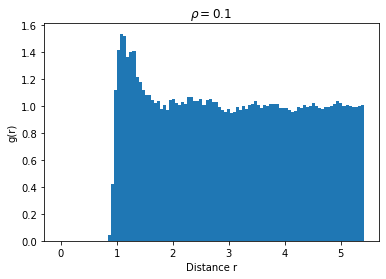

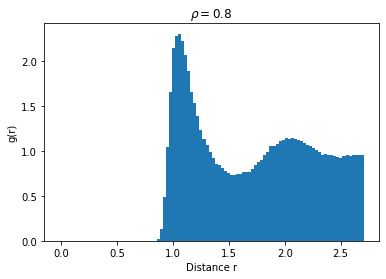

In [23]:
for rho in (0.1, 0.8):
    pm = ParticleManager(N=N, rho=rho, vlim=(-0.1, 0.1), Ndim=3, as_grid=True).remove_translation().scale(T=2).set_initial_a(force).init_hist(bins)
    grid = Grid(pm, dt=dt, force=force)

    if pm.bounds[1] <= rc:
        raise Exception(f"2 * Rc should be larger than the bounds! L={pm.bounds[1]:.2f}, Rc={rc}")

    K = np.zeros(n_go)
    V = np.zeros(n_go)
    P = np.zeros(n_go)

    for _ in range(n_T):
        grid.update()
        grid.pm.scale(T=T0)

    for _ in range(n_e):
        grid.update()

    grid.pm._hist_rdy = True

    for i in range(n_go):
        V[i] = grid.update()
        K[i] = grid.pm.K
        P[i] = grid.pm.P

    plt.figure()
    hist = 2*grid.pm._hist
    bin_range, width = np.linspace(0, pm.bounds[1]/2, bins, retstep=True)
    volumes = 4/3 * np.pi * (bin_range**3 - (bin_range - width)**3)
    g = hist / (rho*volumes*N*n_go)
    plt.bar(bin_range, hist / (rho*volumes*N*n_go), width=width)
    plt.title(r"$\rho =$" + f"{rho}")
    plt.xlabel("Distance r")
    plt.ylabel("g(r)")